# EDA

In [172]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns 
import statistics
import visualisations as vis
import random
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

from sklearn.experimental import enable_iterative_imputer 
from sklearn.impute import IterativeImputer

from sklearn.linear_model import Ridge, RidgeCV, Lasso
from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import RandomForestRegressor


sns.set_theme(context='notebook', style='darkgrid', palette='tab10')

In [173]:
df = pd.read_csv('../data/clean_combined_wines.csv')
# set name column as index
df.set_index('name', inplace=True)
df.head()

,region,country,vintage,producer,wine_variety,grape_variety,price,rating,rating_qty,abv,reviewed_by,from_vivino,log_price,age
name,,,,,,,,,,,,,,
00 Wines Vgw Chardonnay 2017,Willamette Valley,United States,2017,00 Wines,white,Chardonnay,65.71,0.0,0,13.0,"JS, WE, WS",False,4.185251,7
00 Wines Vgr Pinot Noir 2019,Willamette Valley,United States,2019,00 Wines,red,Pinot Noir,82.14,0.0,0,12.9,"WE, JS, RP",False,4.408425,5
00 Wines Egw Chardonnay 2019,Willamette Valley,United States,2019,00 Wines,white,Chardonnay,95.28,0.0,0,NaN,"JS, RP, WE",False,4.556820,5
100 Nails Ranch Pinot Noir 2019,Central Coast,United States,2019,100 Nails Ranch,red,Pinot Noir,13.96,0.0,0,14.2,WW,False,2.636196,5
100 Nails Ranch Chardonnay 2019,Sonoma County,United States,2019,100 Nails Ranch,white,Chardonnay,13.96,0.0,0,14.2,0,False,2.636196,5


In [174]:
print(df.shape)
df.describe()

(49896, 14)


,vintage,price,rating,rating_qty,abv,log_price,age
count,49896.000000,49896.000000,49896.000000,49896.000000,8949.000000,49896.000000,49896.000000
mean,2015.730059,44.211823,3.111496,298.167889,13.639429,3.047707,8.269941
std,3.697926,141.176817,1.585098,751.725910,1.127858,1.010554,3.697926
min,1969.000000,2.080000,0.000000,0.000000,1.200000,0.732368,2.000000
25%,2015.000000,10.000000,3.400000,25.000000,13.000000,2.302585,6.000000
50%,2016.000000,17.840000,3.800000,83.000000,13.800000,2.881442,8.000000
75%,2018.000000,37.260000,4.000000,272.000000,14.500000,3.617920,9.000000
max,2022.000000,8214.650000,5.000000,20293.000000,19.600000,9.013674,55.000000


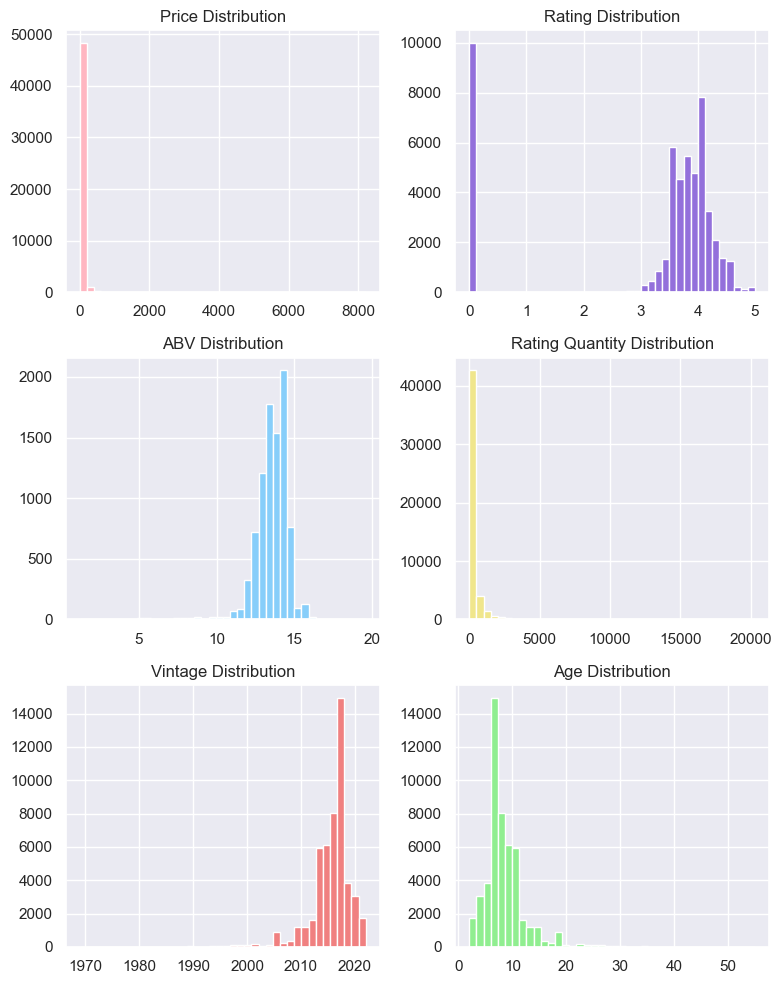

In [175]:

fig, axs = plt.subplots(3, 2, figsize=(8, 10))  
bins = 40
axs[0, 0].hist(df['price'], bins=bins, color='lightpink')
axs[0, 0].set_title('Price Distribution')
axs[0, 0].grid(True)

axs[0, 1].hist(df['rating'], bins=bins, color='mediumpurple')
axs[0, 1].set_title('Rating Distribution')
axs[0, 1].grid(True)

axs[1, 0].hist(df['abv'], bins=bins, color='lightskyblue')
axs[1, 0].set_title('ABV Distribution')
axs[1, 0].grid(True)

axs[1, 1].hist(df['rating_qty'], bins=bins, color='khaki')
axs[1, 1].set_title('Rating Quantity Distribution')
axs[1, 1].grid(True)

axs[2, 0].hist(df['vintage'], bins=bins, color='lightcoral')
axs[2, 0].set_title('Vintage Distribution')
axs[2, 0].grid(True)

axs[2, 1].hist(df['age'], bins=bins, color='lightgreen')
axs[2, 1].set_title('Age Distribution')
axs[2, 1].grid(True)

plt.tight_layout()
# plt.show()


* Prices are heavily right skewed and would likely benefit from a logarithmic transformation before modelling.
* Rating qty also heavily right skewed and would likely benefit from a logarithmic transformation before modelling. Most wine have very few reviews, with some extreme outliers up to 29389. 
* ABV content fairly normally distibuted with clear spike at median of 13.5% 
* High number of observations with zero values in rating and rating_qty which is likely to affect the predictivness of any mode. A wine that has no reviews should not be considered to have a rating of zero. 

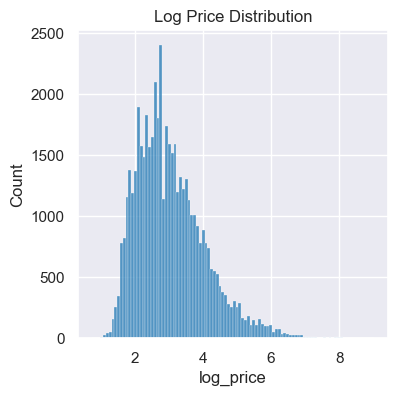

In [176]:
# remove price outliers from dataframe, log transform price and plot

df['log_price'] = np.log(df['price'])
plt.figure(figsize=(4, 4))
plt.title('Log Price Distribution')
sns.histplot(df['log_price'], bins=100)  # kde=False turns off the kernel density estimate plot overlay
plt.show();

* Log price much more normally distributed. 

Max outlier bound log_price: 5.591
Number of remaining rows: 48738, rows removed: 1158


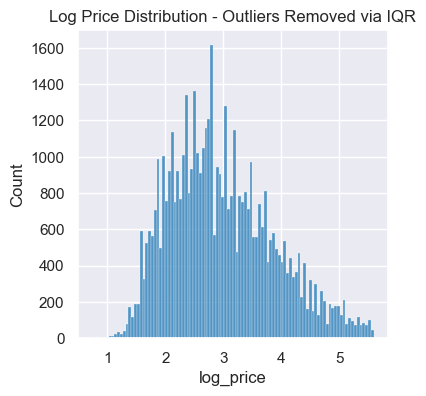

In [177]:
# calculate interquartile range of price, and set a limit at 1.5 IQR above 75% percentile
Qrt1 = np.quantile(df['log_price'], 0.25)
Qrt3 = np.quantile(df['log_price'], 0.75)
price_IQR = Qrt3 - Qrt1
outlier_price_limit = Qrt3 + (price_IQR * 1.5)
df_IQR_price = df[df['log_price'] < outlier_price_limit]
print('Max outlier bound log_price: ', round(outlier_price_limit,3), sep='')
print(f'Number of remaining rows: {df_IQR_price.shape[0]}, rows removed: {df.shape[0] - df_IQR_price.shape[0]}')
plt.figure(figsize=(4, 4))
plt.title('Log Price Distribution - Outliers Removed via IQR')
sns.histplot(df_IQR_price['log_price'], bins=100) 
plt.show();

In [178]:
df['log_price'].describe()

count    49896.000000
mean         3.047707
std          1.010554
min          0.732368
25%          2.302585
50%          2.881442
75%          3.617920
max          9.013674
Name: log_price, dtype: float64

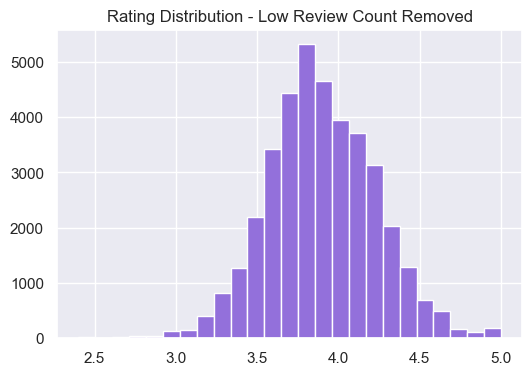

In [179]:
# Filtering out wines with no 10 or fewer reviews
high_rating_qty_only = df[df['rating_qty'] > 10]

plt.figure(figsize=(6, 4))
bins = 25

# Plot for Rating Distribution
plt.hist(high_rating_qty_only['rating'], bins=bins, color='mediumpurple')
plt.title('Rating Distribution - Low Review Count Removed');


In [180]:
high_rating_qty_only['rating'].describe()

count    38566.000000
mean         3.891225
std          0.320886
min          2.400000
25%          3.700000
50%          3.900000
75%          4.100000
max          5.000000
Name: rating, dtype: float64

* Ratings fairly normally distributed around a median of 3.9. Small peak at 5 for wines which have been rated the maximum of 5 stars.

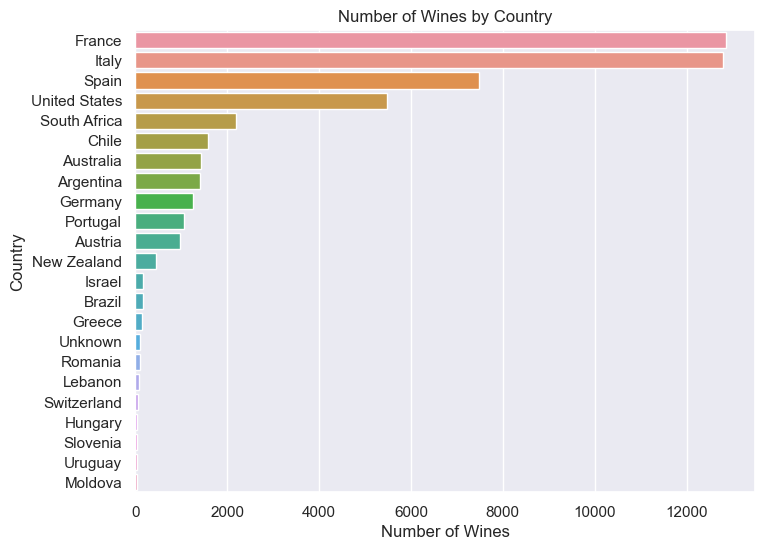

In [181]:
count_wines_by_country = df['country'].value_counts()

plt.figure(figsize=(8, 6))
sns.barplot(x=count_wines_by_country.values, y=count_wines_by_country.index)
plt.xlabel('Number of Wines')
plt.ylabel('Country')
plt.title('Number of Wines by Country');

### ABV - Alcohol Content

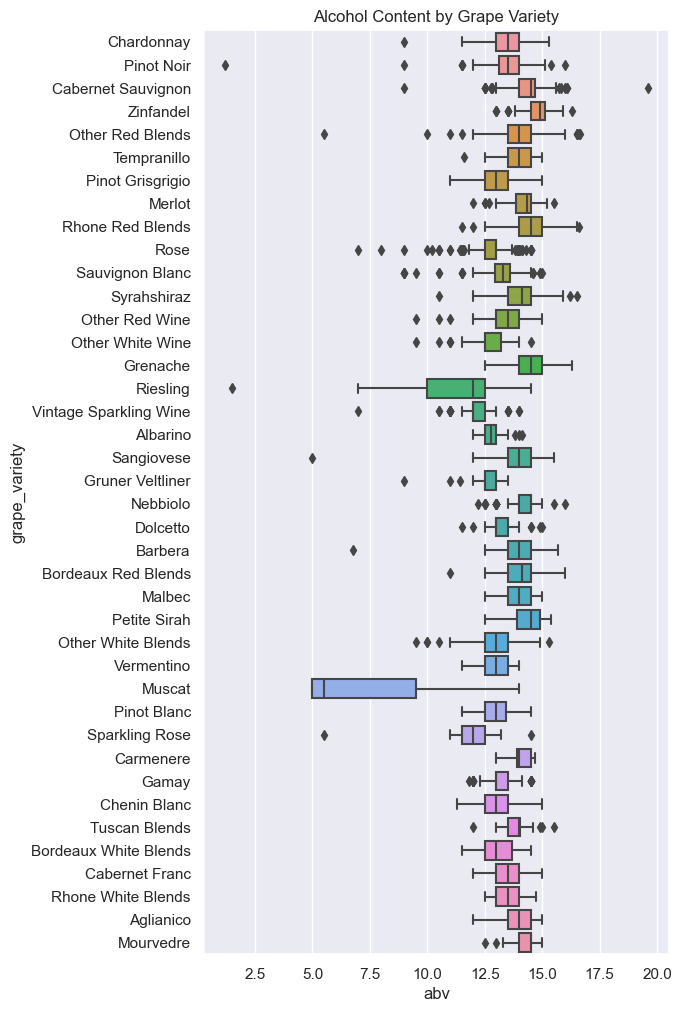

In [182]:
df_a = df[df['abv'].isna() == False]
popular_grape_varieties = df_a[(df_a['grape_variety'].isin((df_a['grape_variety'].value_counts().head(40).index)))]
plt.figure(figsize=(6, 12)) 
sns.boxplot(x='abv', y='grape_variety', data=popular_grape_varieties)
plt.xticks() 
plt.title('Alcohol Content by Grape Variety')
plt.show()


* Fair amount of variation between average abv and abv spread between differing grape varieties. Muscat and Riesling for example are trypically on the lower end of alcohol content.

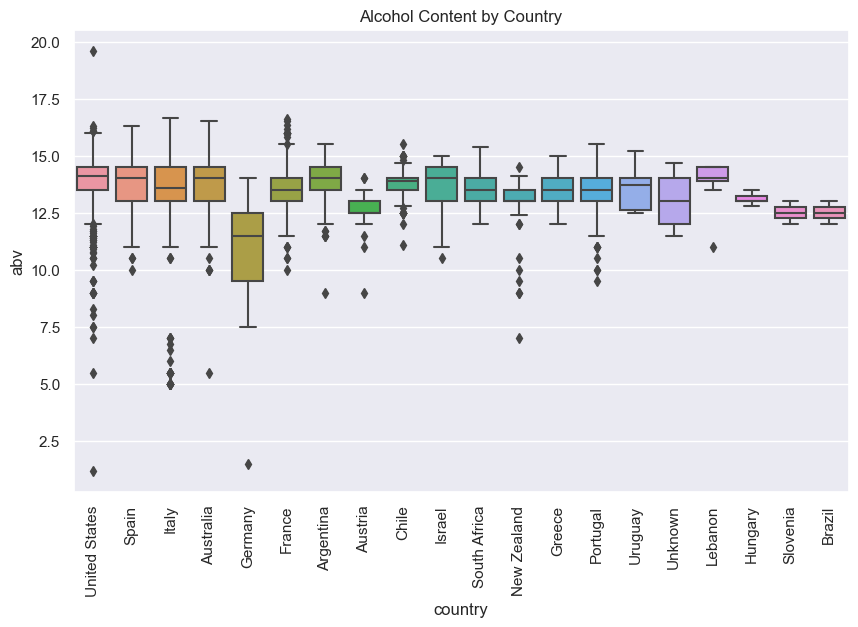

In [183]:
# Box plot for abv 
plt.figure(figsize=(10, 6)) 
sns.boxplot(x='country', y='abv', data=df_a)
plt.xticks(rotation=90) 
plt.title('Alcohol Content by Country')
plt.show()

* Germany, a country known for its Reisling wine is one of the countries with the lowest average alcohol content. 
* Most countries fall between the 15% - 12.5% range 
* Unfortified wines contain anywhere from 5.5% to 16% ABV, with an average in our dataset of 13.6%. 

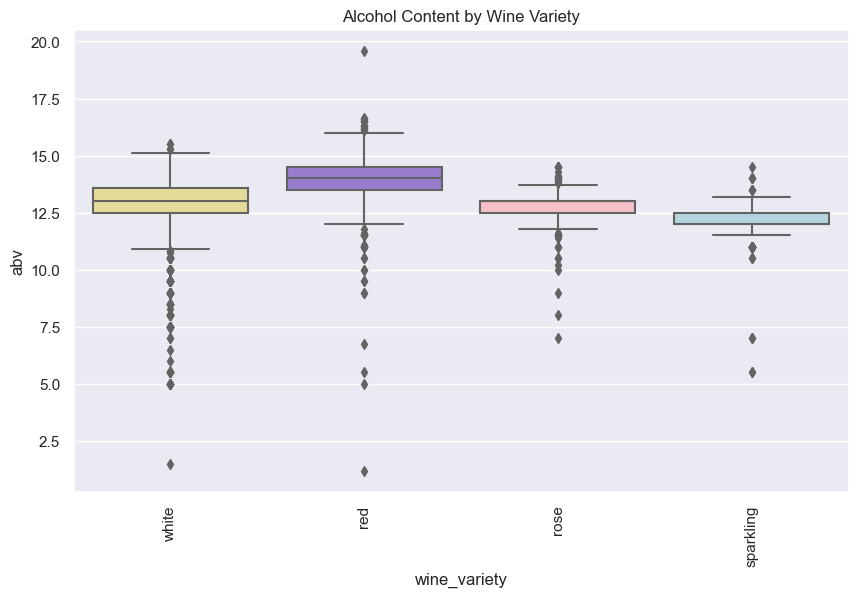

In [184]:
colour_mapping = {
    'red': 'mediumpurple',
    'rose': 'lightpink',
    'white': 'khaki',
    'sparkling': 'lightblue'
}
plt.figure(figsize=(10, 6)) 
sns.boxplot(x='wine_variety', y='abv', data=df_a, palette=colour_mapping)
plt.xticks(rotation=90) 
plt.title('Alcohol Content by Wine Variety')
plt.show()

* Red wines typically have a higher alcohol content than other wine types. 
* Sparkling wines have the lowest. 
* White and rose are in the middle though white has a larger spread than rose overlappying with red and rose wines in abv levels. 

# Correlations

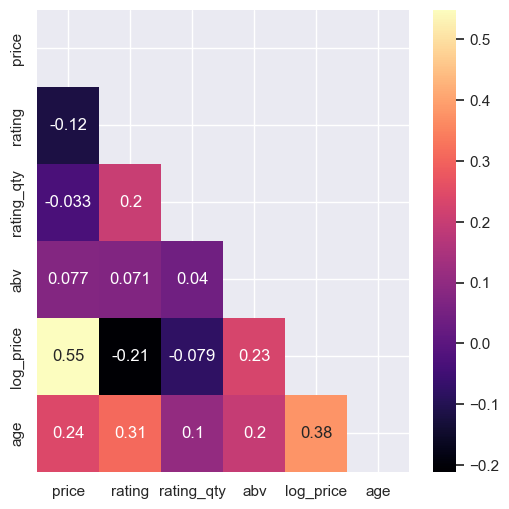

In [185]:
# Correlations on all numeric values - without filtering any data 
numeric = df.drop(columns = [ 'region', 'country', 'vintage', 'producer', 'wine_variety',
       'grape_variety','reviewed_by','from_vivino'])

plt.figure(figsize=(6, 6))

# Set up mask to be "True" in the upper triangle.
mask = np.zeros_like(numeric.corr())
mask[np.triu_indices_from(mask)] = True

sns.heatmap(numeric.corr(), mask = mask, annot=True, cmap='magma');

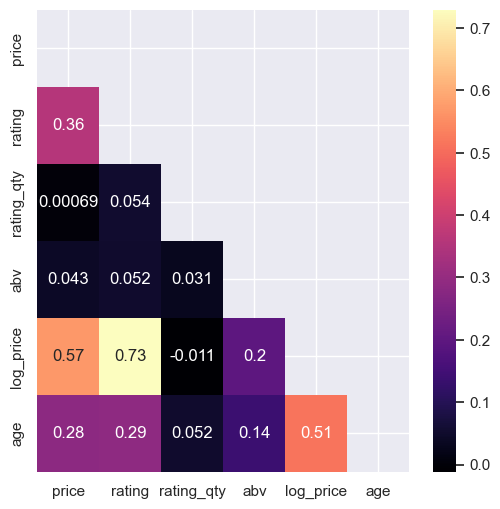

In [186]:
# Filtering data with a minium number of ratings 
numeric = high_rating_qty_only.drop(columns = [ 'region', 'country', 'vintage', 'producer', 'wine_variety',
       'grape_variety','reviewed_by','from_vivino'])

plt.figure(figsize=(6, 6))

# Set up mask to be "True" in the upper triangle.
mask = np.zeros_like(numeric.corr())
mask[np.triu_indices_from(mask)] = True

sns.heatmap(numeric.corr(), mask = mask, annot=True, cmap='magma');

* We can see that rating has a high correlation with price when a minimum number of ratings is set. In this case the minimum was 10. 
* Some positive correlation between log_price and alcohol content. 
* Rating and age have a positive correlation, which is to be expected, as wines age they are known to increase in depth of flavour. Furthermore more expensive wines are those created to age better and are often therefore left to age and more likely to be rated more highly once eventually drunk!
* All correlations are stronger with log_price than price suggesting again that our modelling might perform better with log_price as the target. 

In [187]:
# Calculate interquartile range of price and set a limit at 1.5 IQR above 75% percentile for analysis below
Qrt1 = np.quantile(df['price'], 0.25)
Qrt3 = np.quantile(df['price'], 0.75)
price_IQR = Qrt3 - Qrt1
outlier_price_limit = Qrt3 + (price_IQR * 1.5)
outlier_price_limit

78.15

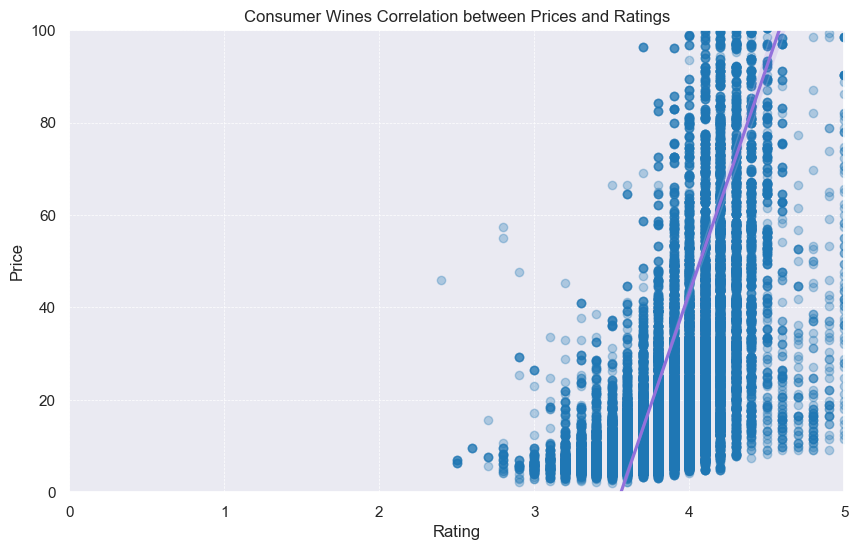

In [188]:
# Focusing only on wines below 78 which is the IQR of price. 
min_rating_qty_consumer_wines = high_rating_qty_only[high_rating_qty_only['price'] < outlier_price_limit]
plt.figure(figsize=(10, 6))
sns.regplot(x='rating', y='price', data=high_rating_qty_only, scatter_kws={'alpha':0.3}, line_kws={'color':'mediumpurple'})
plt.title('Consumer Wines Correlation between Prices and Ratings')
plt.xlabel('Rating')
plt.ylabel('Price')
plt.xlim(0, 5)
plt.ylim(0, 100)
plt.grid(True, which="both", ls="--", linewidth=0.5);

Focusing in on wines below £78.15 and wines with a minimum number of ratings: 
* We can see strong positive correlation between rating and price. 
* No wines with less than an average of 2 star rating. 
* bulk of wines rated around 4. 

# Price

Text(0.5, 1.0, 'Log Price by Wine Variety')

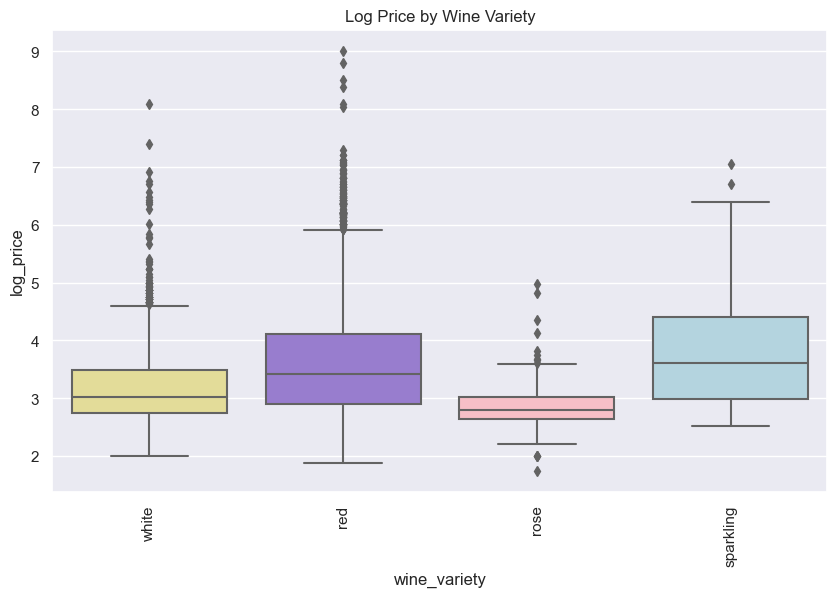

In [189]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='wine_variety', y='log_price', data=df_a, palette=colour_mapping)
plt.xticks(rotation=90)
plt.title('Log Price by Wine Variety')

### Producers and Price

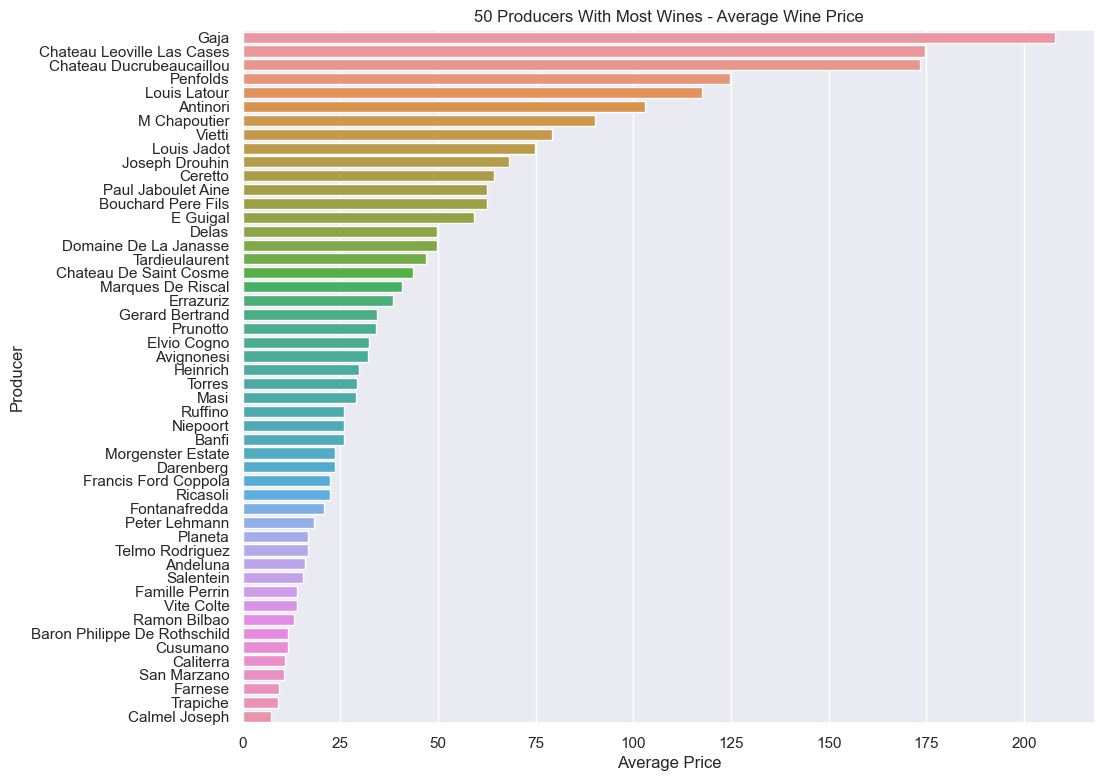

In [190]:
n_producers = 50
top_producers = df['producer'].value_counts().head(n_producers).index
filtered_df = df[df['producer'].isin(top_producers)]
average_prices = filtered_df.groupby('producer')['price'].mean().reset_index()
to_plot = average_prices.sort_values(by='price', ascending=False)

plt.figure(figsize=(11, 9))

sns.barplot(x='price', y='producer', data=to_plot)

plt.xlabel('Average Price')
plt.ylabel('Producer')
plt.title(f'{n_producers} Producers With Most Wines - Average Wine Price');


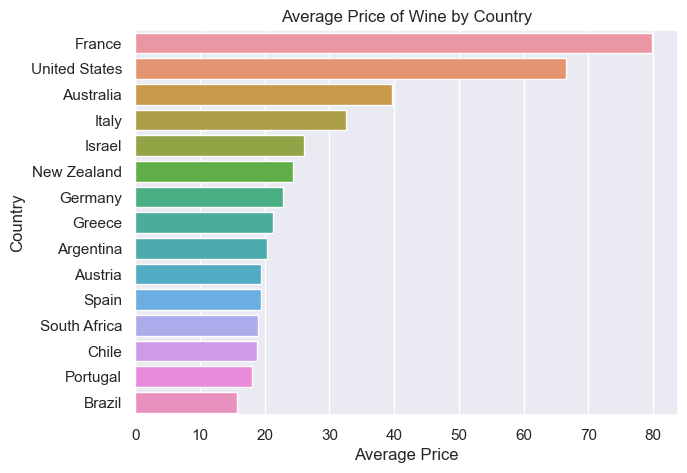

In [191]:
n_countries = 15
countrylist = list(df['country'].value_counts().head(n_countries).index)
top_countries = df[df['country'].isin(countrylist)]
avg_price_by_country = top_countries.groupby('country')['price'].mean().sort_values(ascending=False)

plt.figure(figsize=(7, 5))
sns.barplot(x=avg_price_by_country.values, y=avg_price_by_country.index)
plt.xlabel('Average Price')
plt.ylabel('Country')
plt.title('Average Price of Wine by Country');

## Rating

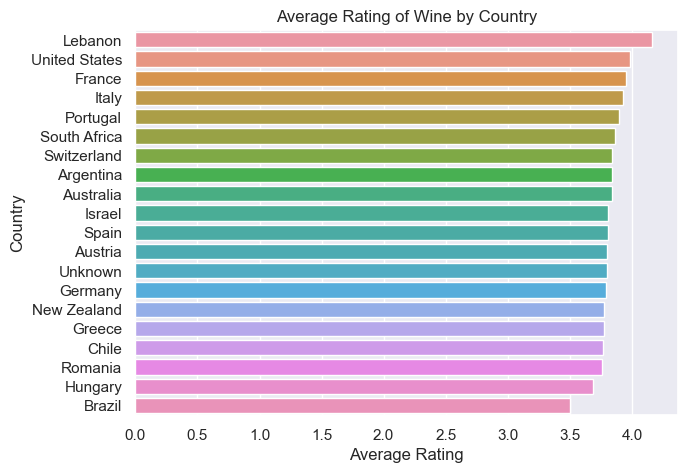

In [192]:
# Average rating by country (using only wines with more than 25 ratings) 
n_countries_r = 20
countrylist = list(df['country'].value_counts().head(n_countries_r).index)
top_countries = high_rating_qty_only[high_rating_qty_only['country'].isin(countrylist)]
avg_rating_by_country = top_countries.groupby('country')['rating'].mean().sort_values(ascending=False)

plt.figure(figsize=(7, 5))
sns.barplot(x=avg_rating_by_country.values, y=avg_rating_by_country.index)
plt.xlabel('Average Rating')
plt.ylabel('Country')
plt.title('Average Rating of Wine by Country');

In [193]:
high_rating_qty_only['country'].value_counts()

country
Italy            10839
France            9513
Spain             6741
United States     2141
South Africa      2036
Chile             1356
Argentina         1074
Australia         1049
Germany           1005
Portugal           952
Austria            890
New Zealand        295
Brazil             160
Romania             92
Unknown             80
Lebanon             61
Greece              59
Israel              52
Switzerland         48
Hungary             38
Moldova             32
Slovenia            32
Uruguay             21
Name: count, dtype: int64

* Suprising to see wines from lebanon with such high average ratings. There are 60 wines with more than 25 rating_qty from Lebanon in our dataset compared to 9258 from france and 1779 from US, so perhaps this is a sampling quirk. 


# Categoricals

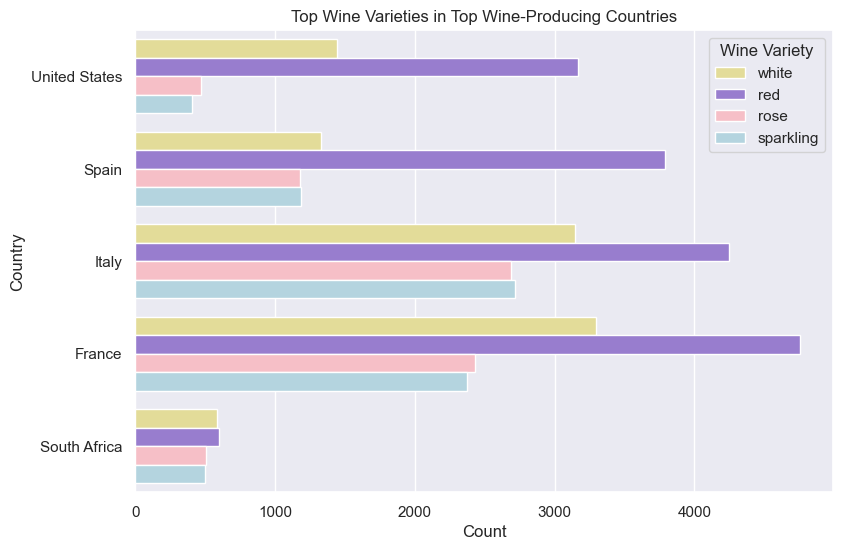

In [194]:
n_countries = 5

colour_mapping = {
    'red': 'mediumpurple',
    'rose': 'lightpink',
    'white': 'khaki',
    'sparkling': 'lightblue'
}

top_countries = df['country'].value_counts().nlargest(n_countries).index
df_top_countries = df[df['country'].isin(top_countries)]

plt.figure(figsize=(9, 6))

sns.countplot(y='country', hue='wine_variety', data=df_top_countries,
              palette=colour_mapping)

plt.xlabel('Count')
plt.ylabel('Country')
plt.title('Top Wine Varieties in Top Wine-Producing Countries')

plt.legend(title='Wine Variety');

* Of the top 5 most appearing countries in our dataset all countries produce red in highest quantity, white is always second and it's close between rose and sparkling.

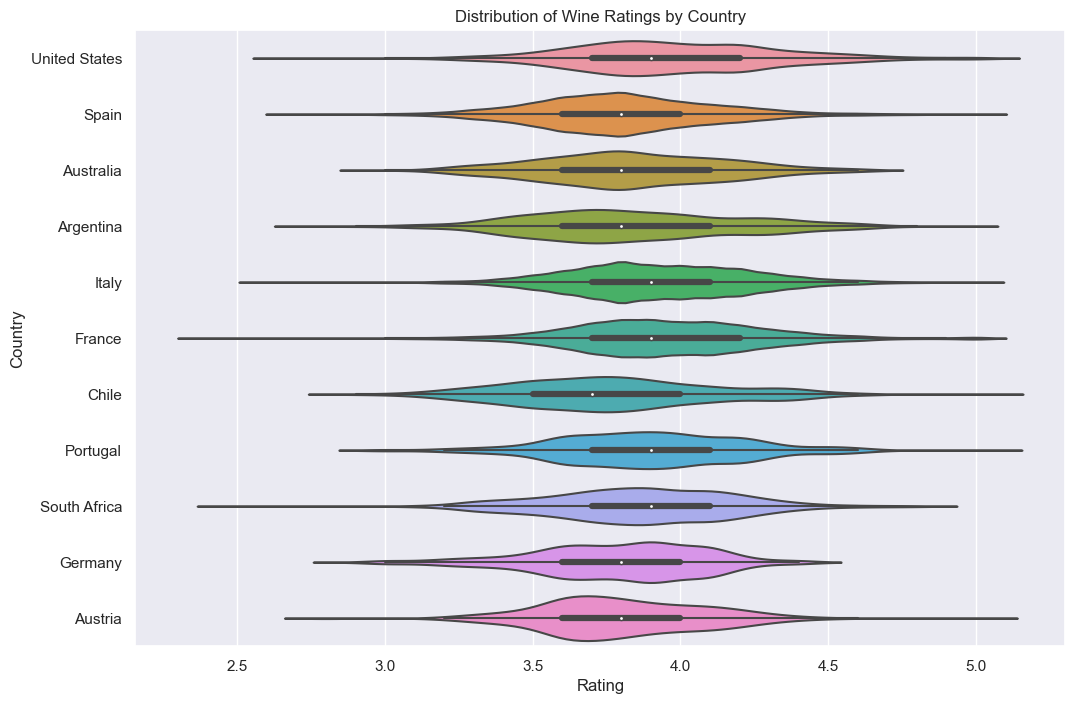

In [195]:
# Filter to include only countries with a significant number of ratings for meaningful comparison
significant_countries = high_rating_qty_only.groupby('country').filter(lambda x: len(x) > 500)

plt.figure(figsize=(12, 8))
sns.violinplot(x='rating', y='country', data=significant_countries)
plt.xlabel('Rating')
plt.ylabel('Country')
plt.title('Distribution of Wine Ratings by Country');

# EDA Functions For Application

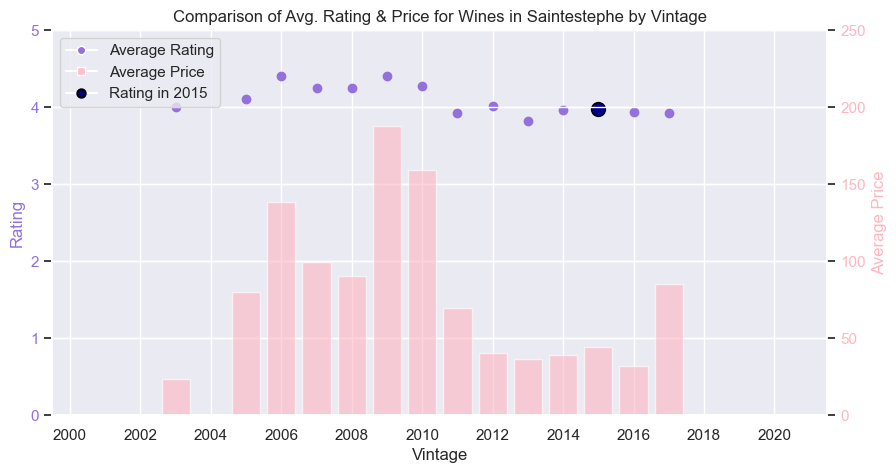

In [197]:
vis.plot_country_vintage_comparison(df, 'Saintestephe', 2015, plot_region=True)

In [198]:
result_df = vis.compare_close_vintages_in_a_country(df, 'Spain', 1995)
result_df

,Vintage,Avg Rating,Avg Price
0,1992,4.00,79.78
1,1995,4.30,121.55
2,1996,3.94,158.65
3,1997,4.30,55.92
4,1998,4.50,44.61


## Finding Underpriced Wines 

In [219]:
# Make a measure for price per star rating 
df['price_per_star'] = df['price'] / df['rating']

# Filter df to only contain wines with 30 or more ratings 
df_rated = df[df['rating_qty'] > 29]

# Make a column which represents the average price per star for each region in a given year (vintage)
avg_price_per_star = df_rated.groupby(['region', 
                                       'vintage']).apply(lambda x: (x['price'].mean() / x['rating'].mean())).reset_index(name='rvint_price_per_star')

# Add this column to df_rated
df_rated= pd.merge(df_rated, avg_price_per_star, on=['region', 'vintage'], how='left')

# Remove columns we wont be using
df_rated.drop(columns=['from_vivino', 'reviewed_by'], inplace=True)
df_rated


,region,country,vintage,producer,wine_variety,grape_variety,price,rating,rating_qty,abv,log_price,age,price_per_star,rvint_price_per_star
0,Ribera del Duero,Spain,2012,12 Linajes,red,Tempranillo,32.85,3.9,33,14.0,3.491952,12,8.423077,8.423077
1,Columbia Valley,United States,2018,14 Hands,red,Cabernet Sauvignon,9.85,3.7,31,13.5,2.287471,6,2.662162,4.827638
2,unknown,Australia,2020,19 Crimes,red,Cabernet Sauvignon,9.03,3.9,68,NaN,2.200552,4,2.315385,2.722658
3,unknown,Australia,2020,19 Crimes,red,Pinot Noir,8.21,3.7,31,13.5,2.105353,4,2.218919,2.722658
4,California,United States,2020,19 Crimes,rose,Rose,11.49,3.9,32,10.5,2.441477,4,2.946154,3.513288
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35765,Valencia,Spain,2017,Loxera,red,Unknown,10.73,3.7,116,NaN,2.373044,7,2.900000,1.708439
35766,Carinena,Spain,2015,Vinos Del Viento Michael Cooper,red,Unknown,10.73,4.0,51,NaN,2.373044,9,2.682500,2.167577
35767,Jumilla,Spain,2018,Luzon,red,Unknown,10.73,3.9,261,NaN,2.373044,6,2.751282,1.689162
35768,Toro,Spain,2018,Tridente,red,Unknown,10.73,3.8,174,NaN,2.373044,6,2.823684,2.052318


In [220]:
# Make a column for region-vintage combinations
df_rated['region_vintage'] = df_rated['region'] + '-' + df_rated['vintage'].astype(str)

# Remove wines with unknown regions
df_rated = df_rated[df_rated['region'] != 'Unknown'].copy()

# Make a list of region vintage combinations that have 30 or more observations - REDO 
rvint_list = df_rated['region_vintage'].value_counts().head(266).index
df_rated_shortlist = df_rated[df_rated['region_vintage'].isin(rvint_list)].copy()

# Make a column for the difference between the average price per star and the average price per star for each region-vintage
df_rated_shortlist['price_per_star_diff'] = df_rated_shortlist['price_per_star'] - df_rated_shortlist['rvint_price_per_star']

In [221]:
# Isolate producers wine representations in 4 or more vintages
producers_with_4_or_more_vintages = df_rated_shortlist.groupby('producer')['vintage'].nunique().loc[lambda x: x >= 4].index

final_df = df_rated_shortlist[df_rated_shortlist['producer'].isin(producers_with_4_or_more_vintages)]

In [272]:
def plot_producer_price_per_star(df, xlim = 2020, ylim = 40):
    for producer in df['producer'].unique():
        producer_df = df[df['producer'] == producer].sort_values('vintage')
        print(producer)
        plt.figure(figsize=(6, 4))
        plt.plot('vintage', 'price_per_star', data=producer_df, label='Price Per Star', 
                 marker='o', color = 'mediumpurple') 
        plt.plot('vintage', 'rvint_price_per_star', data=producer_df, label='RVint Price Per Star', 
                 linestyle='--', marker='x', color = 'lightpink')
        plt.xlabel('Vintage')
        plt.ylabel('Price Per Star Metrics')
        plt.ylim(0, ylim)
        plt.xlim(2010, xlim)
        plt.title(f'Price Per Star Comparison for {producer}')
        plt.legend();

#### France

In [259]:
france_shortlist = final_df[final_df['country'] == 'France'].copy()
top_20_france = france_shortlist.groupby('producer')['price_per_star_diff'].mean().sort_values(ascending=True).head(80).index
france_shortlist_20 = france_shortlist[france_shortlist['producer'].isin(top_20_france)]

# Filter for regions with region vintage representations of 10 or more 
competitive_france_regions = france_shortlist_20.groupby('region_vintage').filter(lambda x: len(x) >= 10)
france_region_list = ['Margaux','Saintjulien', 'Saintemilion Grand Cru']

In [260]:
almost_final_france = competitive_france_regions[competitive_france_regions['region'].isin(france_region_list)].copy()

In [285]:
final_france_producers = almost_final_france.groupby('producer')['price_per_star_diff'].mean().sort_values(ascending=True).head(6).index

In [286]:
final_france = almost_final_france[almost_final_france['producer'].isin(final_france_producers)]

In [287]:
margaux = final_france[final_france['region'] == 'Margaux']

Chateau Labegorce
Chateau Prieurelichine
Chateau Branaireducru
Clos Dubreuil
Chateau La Serre
Clos De Loratoire


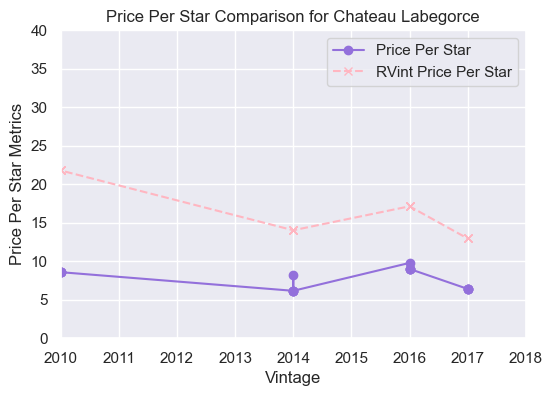

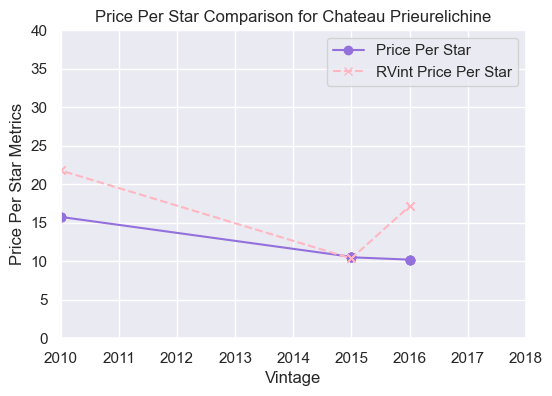

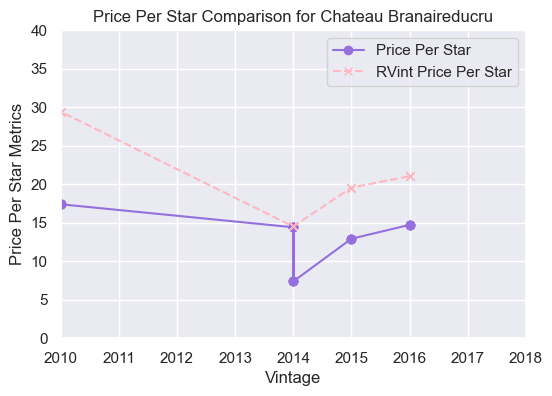

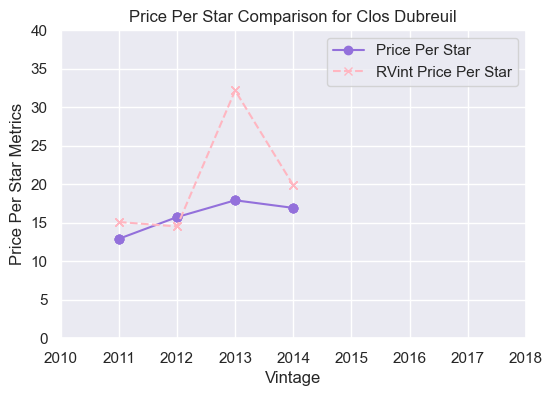

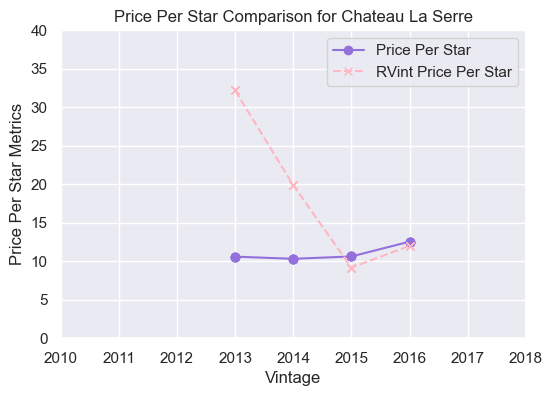

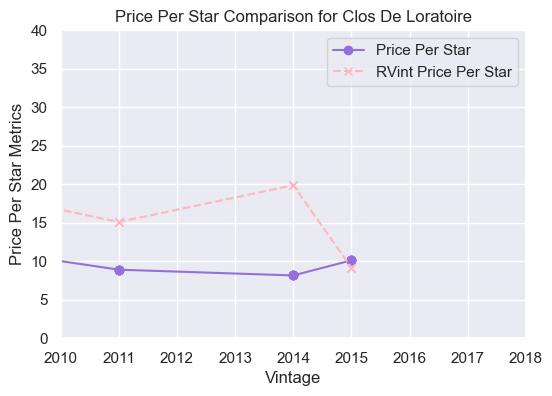

In [288]:
# This is a list of 
plot_producer_price_per_star(final_france, xlim=2018)

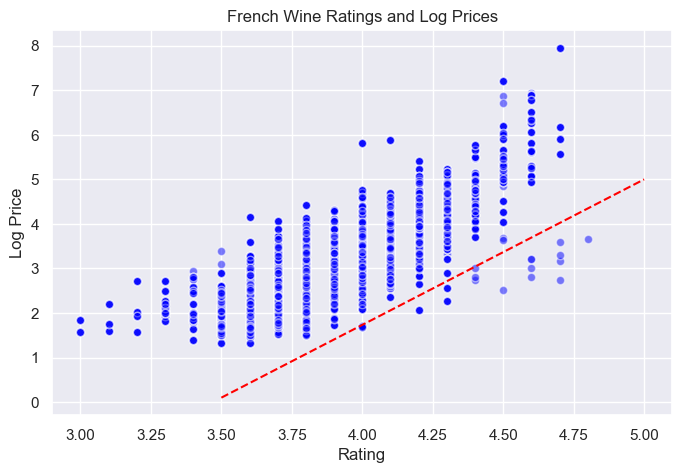

In [317]:
# https://stackoverflow.com/questions/36470343/how-to-draw-a-line-with-matplotlib 

df_france_rated_shortlist = df_rated_shortlist[df_rated_shortlist['country'] == 'France'].copy()

plt.figure(figsize=(8, 5))
plt.scatter(df_france_rated_shortlist['rating'], df_france_rated_shortlist['log_price'], 
            alpha=0.5, c='blue', edgecolors='w', label='Wine')

x, y = [3.5, 5], [0.1, 5]
# # Plotting the line
plt.plot(x, y, 'r--', label='bargains')

plt.title('French Wine Ratings and Log Prices')
plt.xlabel('Rating')
plt.ylabel('Log Price');

In [318]:
x1, y1 = 3.5, 0.1
x2, y2 = 5, 5
m = (y2 - y1) / (x2 - x1)
b = y1 - m * x1

# Step 2: Define a function to determine if a wine is to the right of the line
def is_right_of_line(rating, log_price):
    # Calculate the y value on the line for this x (rating)
    y_line = m * rating + b
    # If the wine's log_price is greater than y_line, it's to the right of the line
    return log_price > y_line

# Apply the function to each row in the DataFrame
df_france_rated_shortlist['bargain'] = df_france_rated_shortlist.apply(
    lambda row: is_right_of_line(row['rating'], row['log_price']), axis=1)


In [323]:
df_france_rated_shortlist[df_france_rated_shortlist['bargain'] ==False].sort_values(by= 'log_price_per_star')

,region,country,vintage,producer,wine_variety,grape_variety,price,rating,rating_qty,abv,log_price,age,price_per_star,log_price_per_star,log_rvint_price_per_star,region_vintage,log_price_per_star_diff,bargain
20979,Pays Doc,France,2018,Les Belles Lavandieres,white,Syrah,5.35,4.0,34,NaN,1.677097,6,1.337500,0.419274,0.481531,Pays Doc-2018,-0.062257,False
29199,Pays Doc,France,2018,Les Belles Lavandieres,sparkling,Syrah,5.35,4.0,34,NaN,1.677097,6,1.337500,0.419274,0.481531,Pays Doc-2018,-0.062257,False
12759,Pays Doc,France,2018,Les Belles Lavandieres,rose,Syrah,5.35,4.0,34,NaN,1.677097,6,1.337500,0.419274,0.481531,Pays Doc-2018,-0.062257,False
4539,Pays Doc,France,2018,Les Belles Lavandieres,red,Syrah,5.35,4.0,34,NaN,1.677097,6,1.337500,0.419274,0.481531,Pays Doc-2018,-0.062257,False
1375,Pays Doc,France,2017,Philibert Du Charme,red,Merlot,5.53,4.0,123,NaN,1.710188,7,1.382500,0.427547,0.524666,Pays Doc-2017,-0.097119,False
9595,Pays Doc,France,2017,Philibert Du Charme,rose,Merlot,5.53,4.0,123,NaN,1.710188,7,1.382500,0.427547,0.524666,Pays Doc-2017,-0.097119,False
26035,Pays Doc,France,2017,Philibert Du Charme,sparkling,Merlot,5.53,4.0,123,NaN,1.710188,7,1.382500,0.427547,0.524666,Pays Doc-2017,-0.097119,False
17815,Pays Doc,France,2017,Philibert Du Charme,white,Merlot,5.53,4.0,123,NaN,1.710188,7,1.382500,0.427547,0.524666,Pays Doc-2017,-0.097119,False
9171,Pays Doc,France,2018,Domaine La Grange,rose,NaN,7.84,4.2,108,NaN,2.059239,6,1.866667,0.490295,0.481531,Pays Doc-2018,0.008764,False
951,Pays Doc,France,2018,Domaine La Grange,red,NaN,7.84,4.2,108,NaN,2.059239,6,1.866667,0.490295,0.481531,Pays Doc-2018,0.008764,False


#### Producers 

**Find producers that are consistently beating the price/rating ratio for their given region_vintage.**

Italy

In [258]:
italy_shortlist = df_rated_shortlist[df_rated_shortlist['country'] == 'Italy'].copy()
top_20_italy = italy_shortlist.groupby('producer')['price_per_star_diff'].mean().sort_values(ascending=True).head(80).index
top_20_italy

KeyError: 'Column not found: price_per_star_diff'

In [ ]:
italy_shortlist_20 = italy_shortlist[italy_shortlist['producer'].isin(top_20_italy)]
print(italy_shortlist_20['region'].value_counts())

region
Toscana                       284
Barolo                        180
Brunello Di Montalcino        140
Barbera Dalba                  48
Langhe                         40
Barbera Dasti                  28
Chianti Classico               28
Barbaresco                     28
Rosso Di Montalcino            28
Maremma Toscana                 8
Bolgheri                        4
Amarone Della Valpolicella      4
Name: count, dtype: int64


In [ ]:
# Try with log_price 

df['log_price_per_star'] = df['log_price'] / df['rating']
df_rated = df[df['rating_qty'] > 30]
avg_price_per_star = df_rated.groupby(['region', 
                                       'vintage']).apply(lambda x: (x['log_price'].mean() / x['rating'].mean())).reset_index(name='log_rvint_price_per_star')

df_rated= pd.merge(df_rated, avg_price_per_star, on=['region', 'vintage'], how='left')
df_rated.drop(columns=['from_vivino', 'reviewed_by'], inplace=True)
df_rated['region_vintage'] = df_rated['region'] + '-' + df_rated['vintage'].astype(str)
df_rated = df_rated[df_rated != 'Unknown'].copy()

rvint_list = df_rated['region_vintage'].value_counts().head(266).index
df_rated_shortlist = df_rated[df_rated['region_vintage'].isin(rvint_list)].copy()
df_rated_shortlist['log_price_per_star_diff'] = df_rated_shortlist['log_price_per_star'] - df_rated_shortlist['log_rvint_price_per_star']

In [ ]:
italy_shortlist = df_rated_shortlist[df_rated_shortlist['country'] == 'Italy'].copy()
top_50_italy_log = italy_shortlist.groupby('producer')['log_price_per_star_diff'].mean().sort_values(ascending=True).head(50).index

italy_shortlist_50_log = italy_shortlist[italy_shortlist['producer'].isin(top_50_italy_log)]
print(italy_shortlist_50_log['region'].value_counts())

region
Toscana                                72
Barolo                                 52
Barbera Dalba                          24
Barbera Dasti                          20
Chianti Classico                       16
Langhe                                 16
Brunello Di Montalcino                 12
Veneto                                 12
Barbaresco                              8
Montepulciano Dabruzzo                  8
Terre Siciliane                         8
Maremma Toscana                         4
Amarone Della Valpolicella              4
Chianti                                 4
Amarone Della Valpolicella Classico     4
Name: count, dtype: int64


In [ ]:
def plot_producer_price_per_star(df):
    plt.figure(figsize=(8, 5))
    for producer in df['producer'].unique():
        producer_df = df[df['producer'] == producer].sort_values('vintage')
        plt.figure(figsize=(6, 4))
        plt.plot('vintage', 'price_per_star', data=producer_df, label='Price Per Star', marker='o')
        plt.plot('vintage', 'rvint_price_per_star', data=producer_df, label='Region Vintage Average', linestyle='--', marker='x')
        plt.xlabel('Vintage')
        plt.ylabel('Price Per Star Metrics')
        plt.title(f'Price Per Star Comparison for {producer}')
        plt.legend()

Renzo Masi
Vite Colte
Vallepicciola
Falesco
Musella
Barbanera
Lenotti
Franco Molino
Danzante
Doppio Passo
Famiglia Castellani
Boasso
Serpaia Di Endrizzi
Poggio Alla Sala
Bulgarini
Albola
Terrescure
Tenuta Di Ceppaiano
Tassi
Cantina Del Taburno
Ricossa
Fattoria Le Corti
Vinea Familiae
Itinera
Melini
Lo Zoccolaio
Tenuta Podernovo


/var/folders/8r/dqs6y1qn77d917x96kct6x5h0000gn/T/ipykernel_75341/918117901.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(6, 4))


Kris
Roberto Sarotto
Muro Antico
Poggio Civetta
Cascina Adelaide
Tiberio
Broccardo
Pira Luigi
Marco Bonfante
Tenuta Cucco
Vignamaggio
Monte Pietroso
Albino Armani
Ca Bolani
Poggio Delle Faine
Elio Filippino
Masseria Coste Di Brenta
Vincenzo Bossotti
Cantine Luciani
Le Chiantigiane
Caldora
Teruzzi Puthod
Terenzi


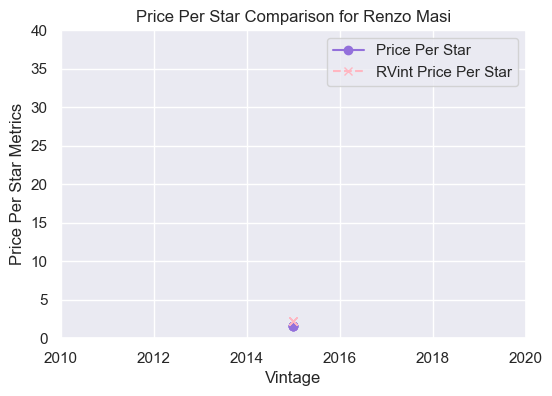

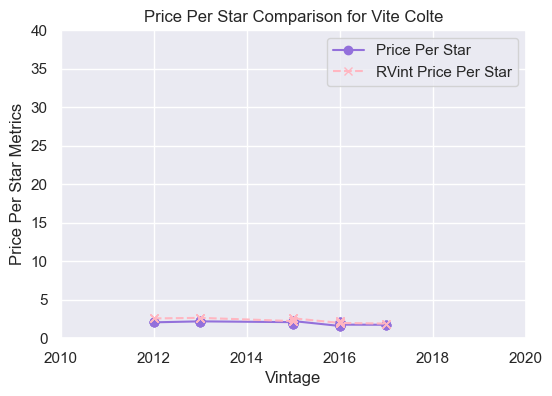

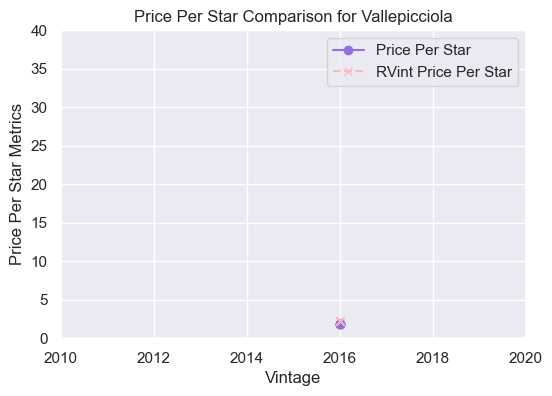

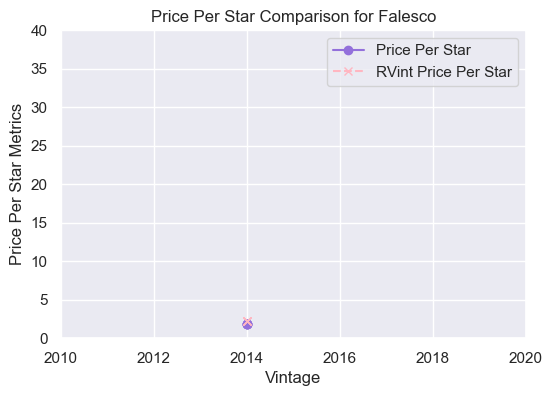

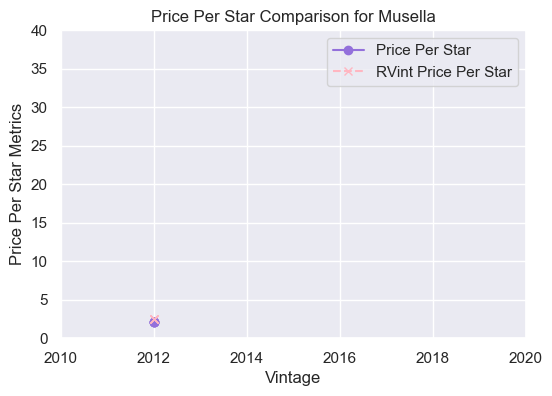

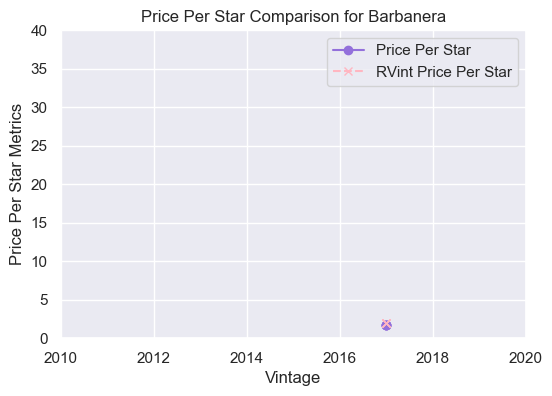

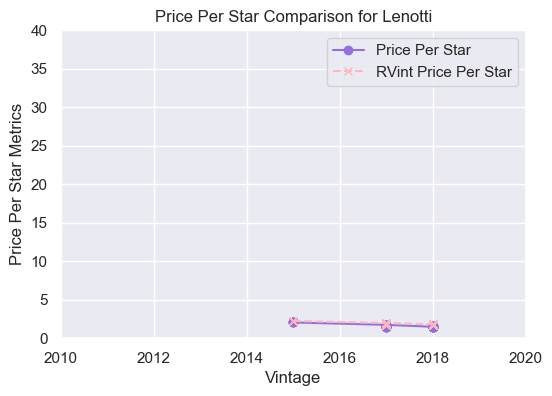

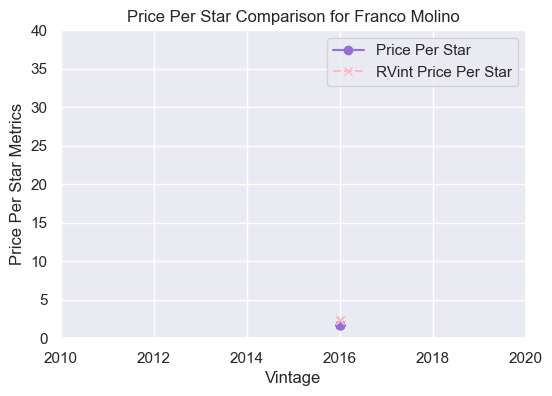

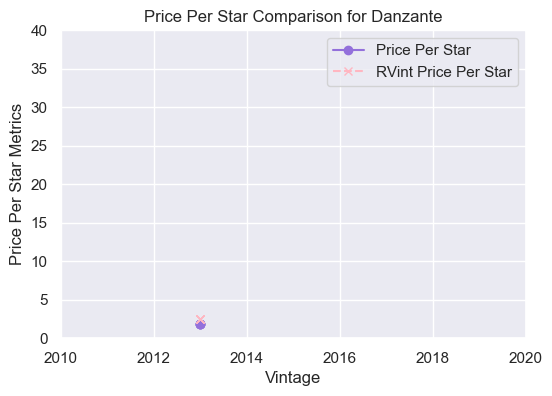

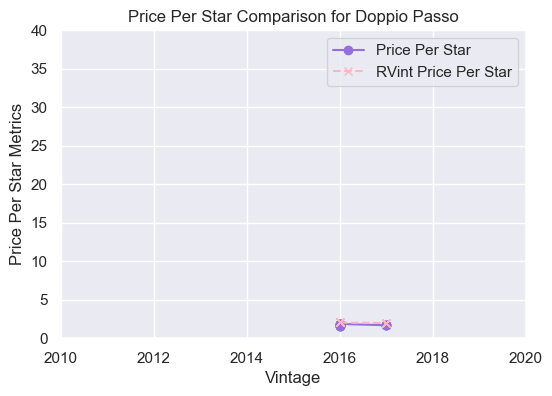

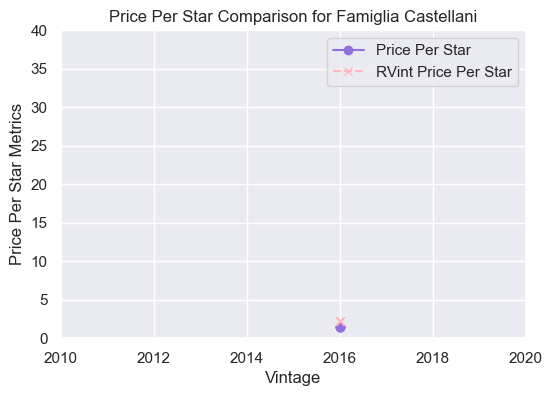

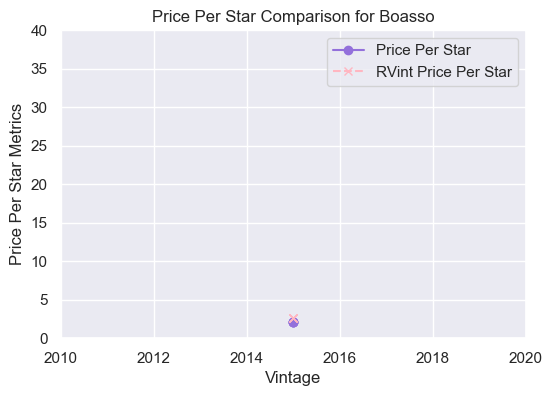

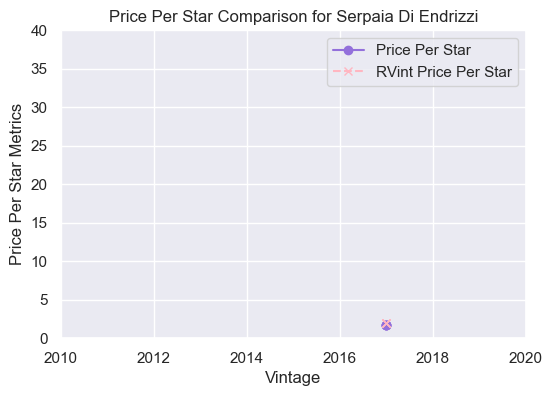

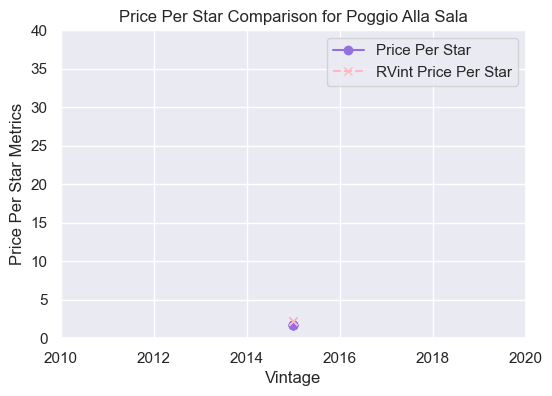

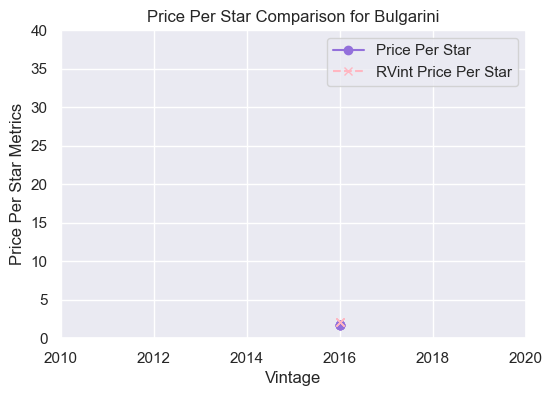

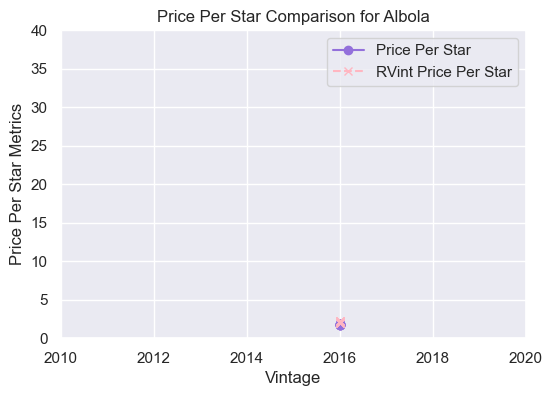

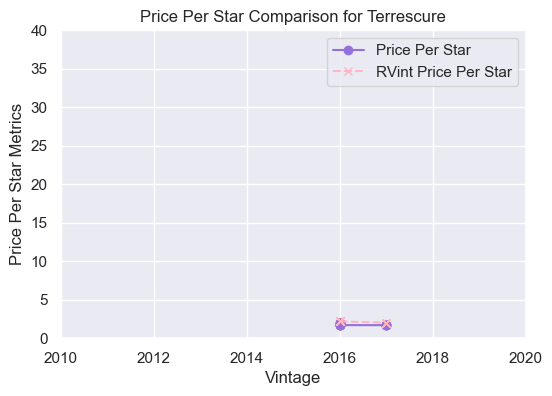

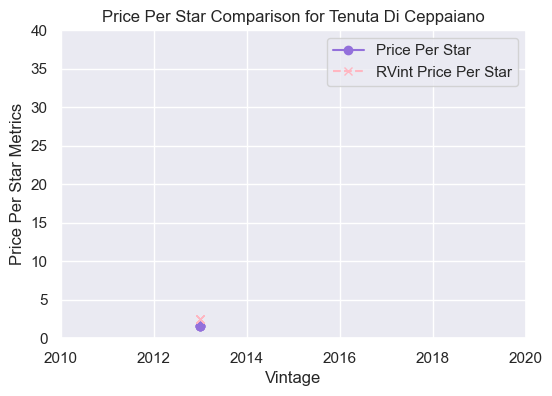

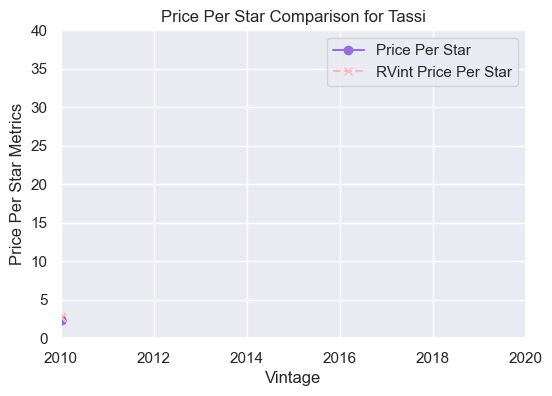

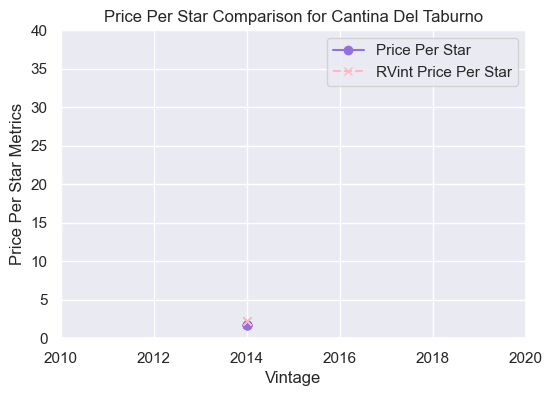

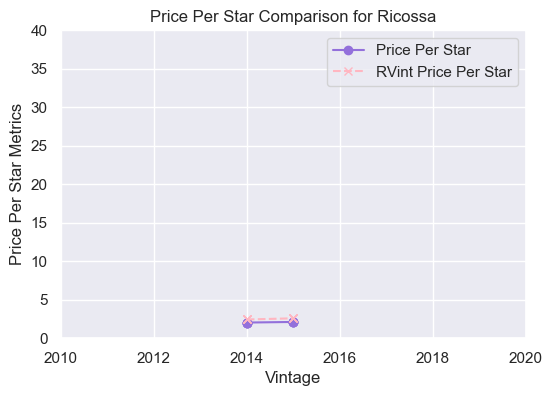

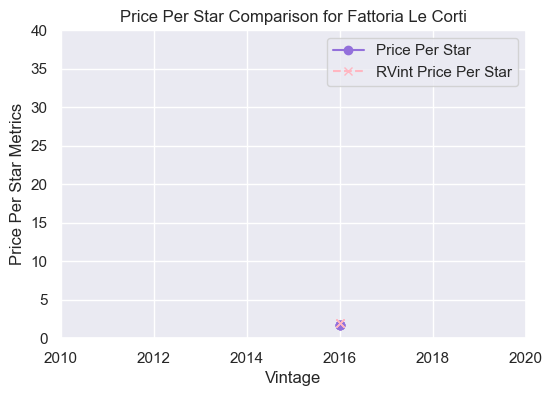

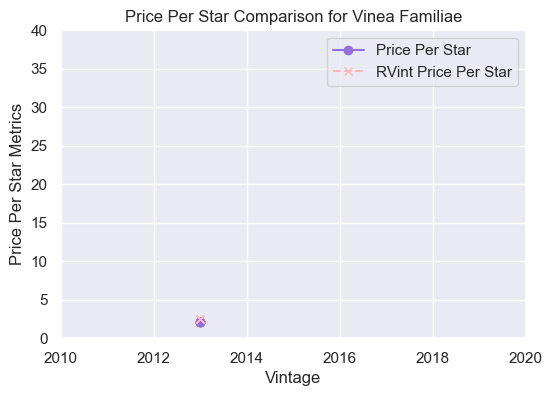

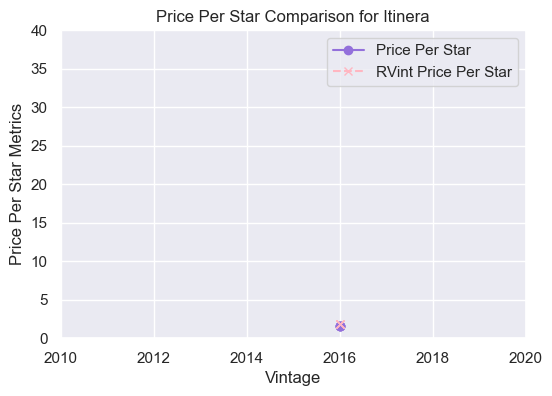

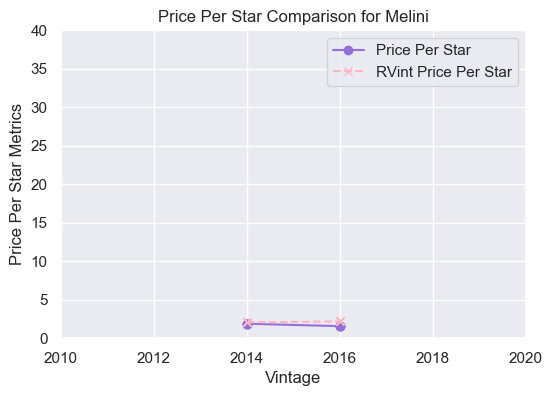

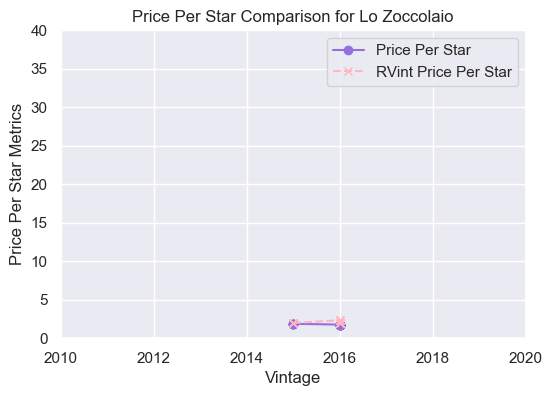

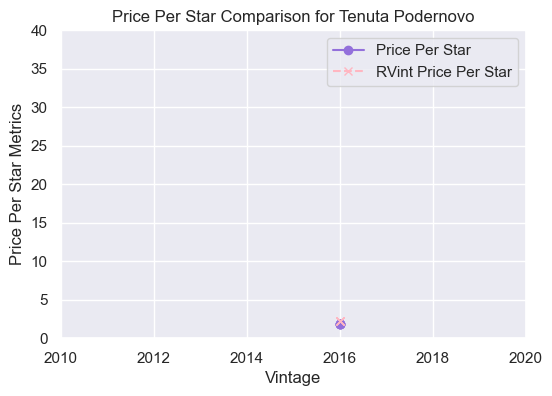

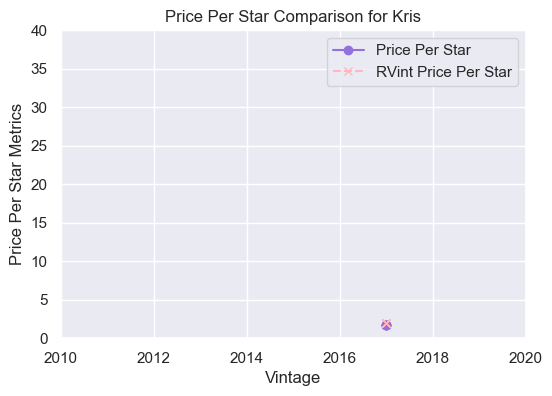

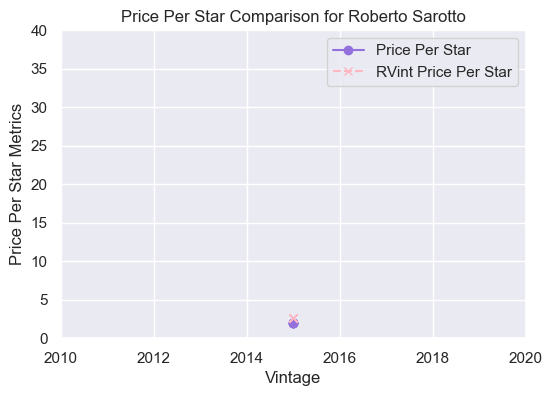

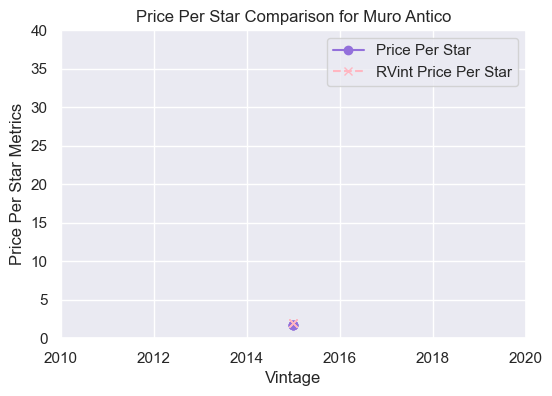

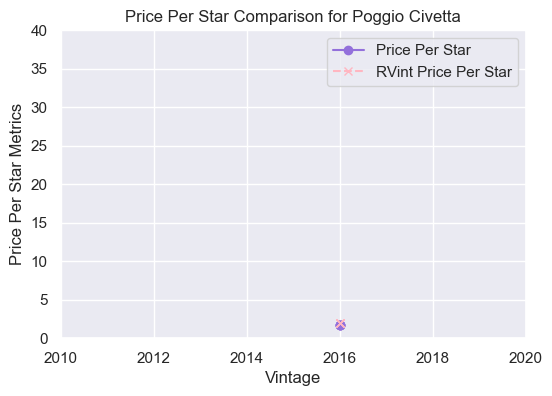

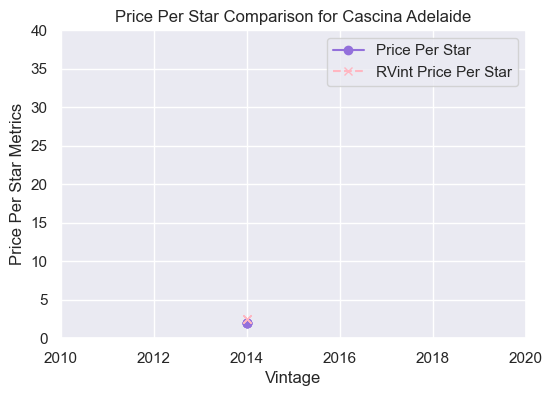

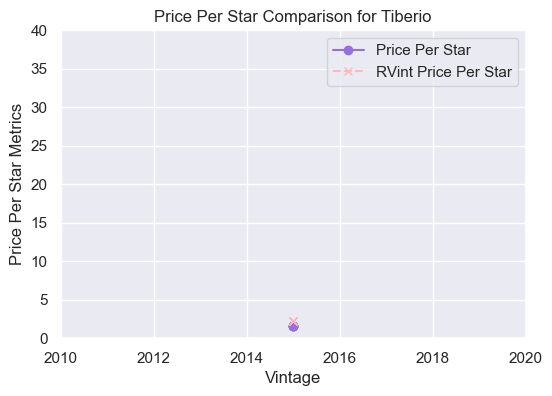

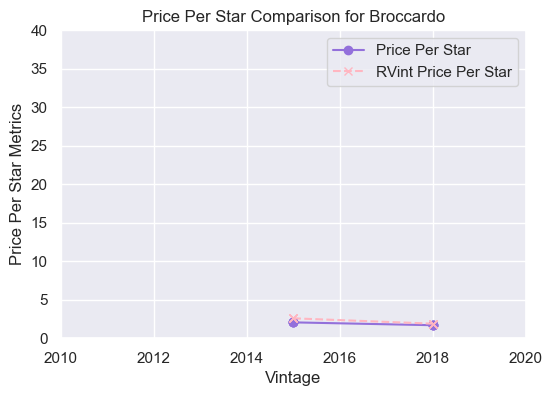

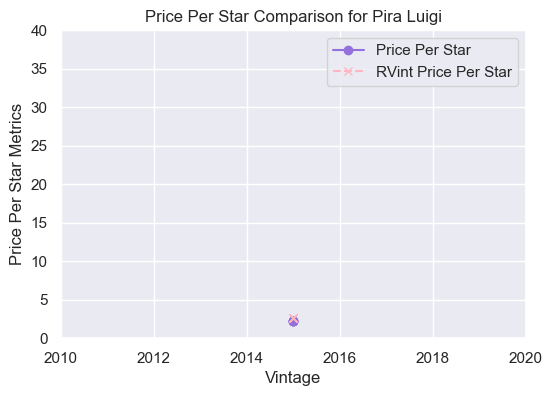

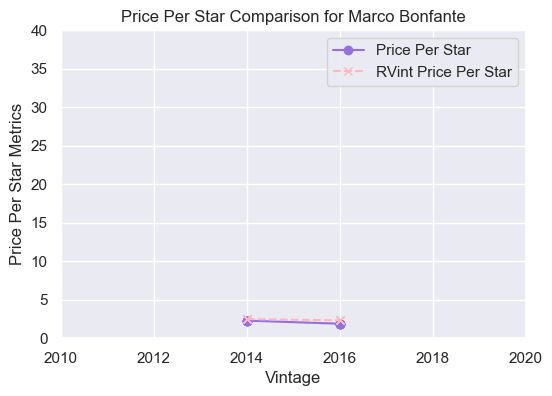

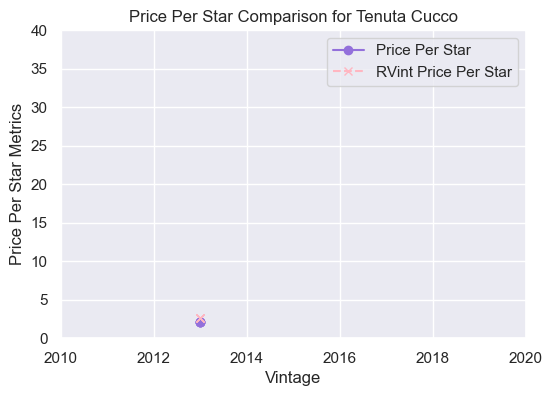

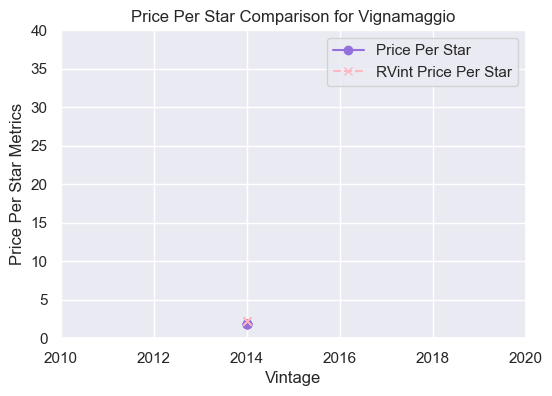

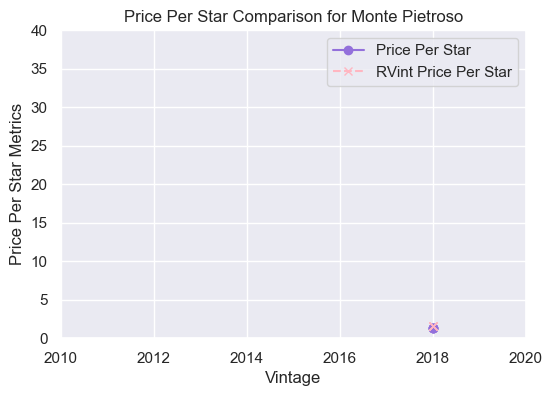

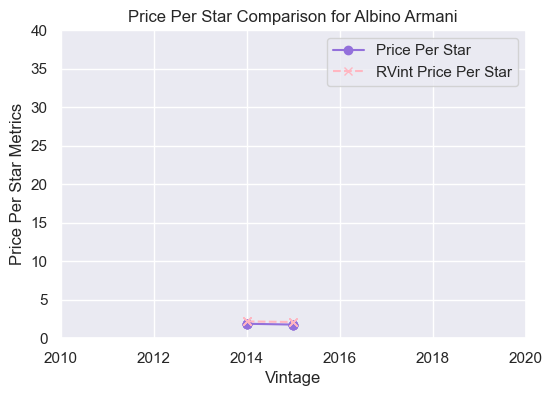

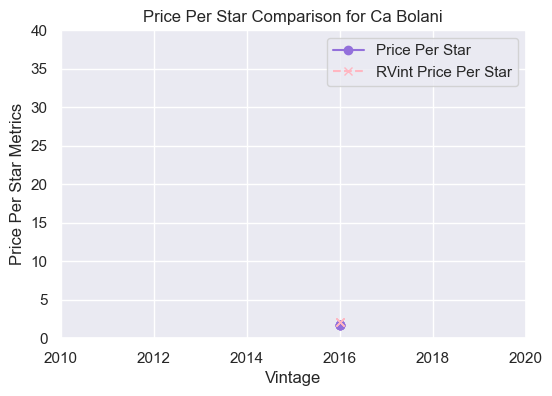

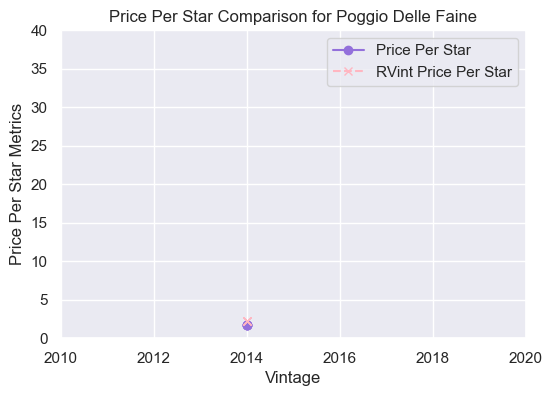

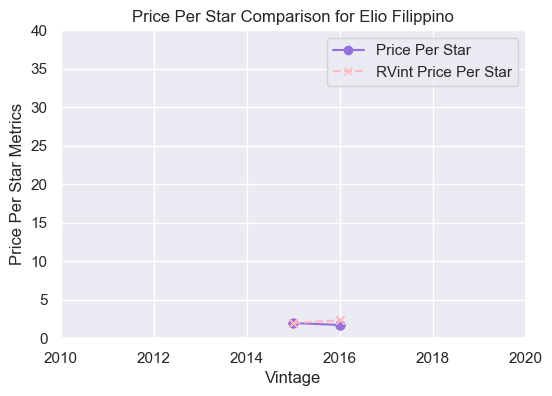

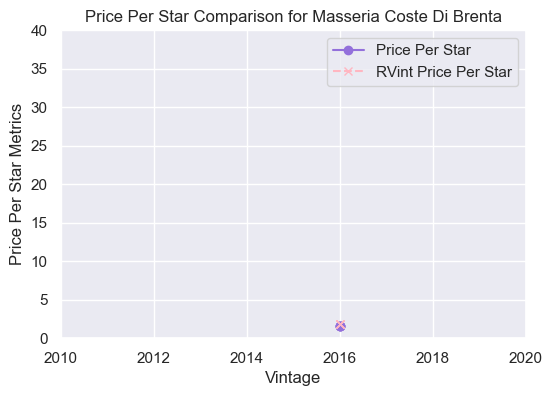

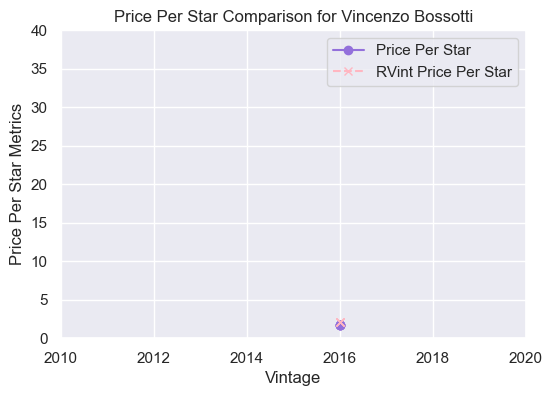

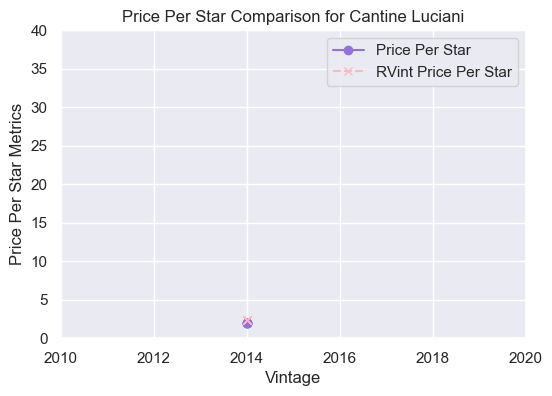

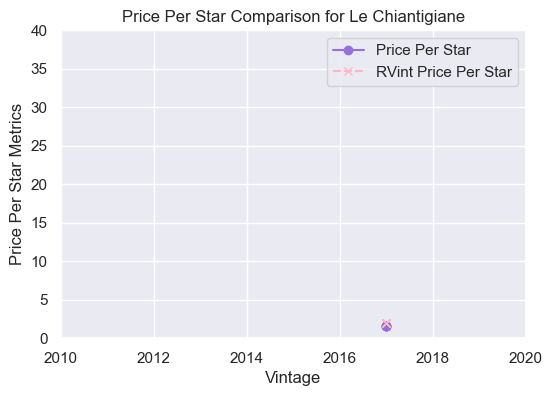

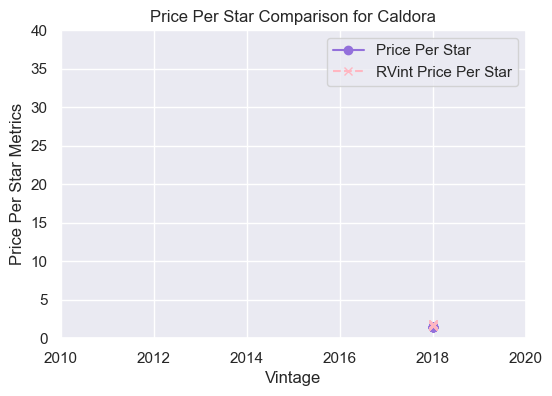

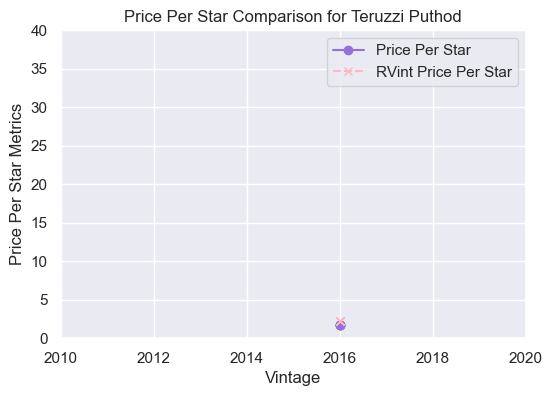

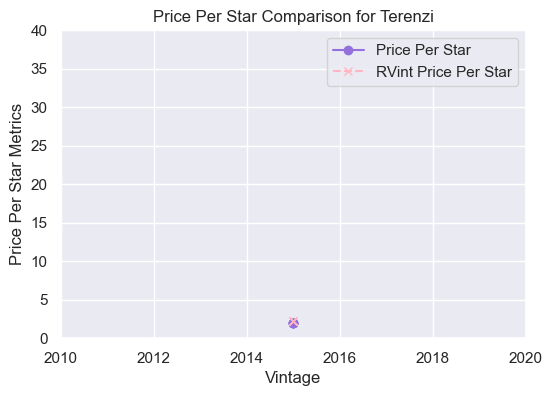

In [322]:
italy_shortlist_50_log['price_per_star'] = italy_shortlist_50_log['log_price_per_star'].apply(lambda x: np.exp(x)).copy()
italy_shortlist_50_log['rvint_price_per_star'] = italy_shortlist_50_log['log_rvint_price_per_star'].apply(lambda x: np.exp(x)).copy()
    
plot_producer_price_per_star(italy_shortlist_50_log)